<a href="https://colab.research.google.com/github/shiwangi27/googlecolab/blob/main/transformer_pytorch_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### PyTorch for building and training Transformer NLP models from scratch. 

This is an implementation of Transformers from the [Attention is All You Need](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) paper by Vaswani et al. 

For this implementation, I have referred Andrej Karpathy's [minGPT](https://github.com/karpathy/minGPT/blob/master/mingpt).

I have tried explaining each step in comments for better understanding.

In [ ]:
import math
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F 

In [ ]:
X_train_embeddings = torch.rand(size=(32, 128, 512), dtype=torch.float32, device="cpu") 

In [ ]:
class TransformerConfig:
  embedding_dropout: float = 0.1 
  attention_dropout: float = 0.1
  residual_dropout: float = 0.1 
  
  activation: nn.functional = F.relu
  bias: bool = True
  mask: bool = False
  
  def __init__(self, 
               vocab_size: int, 
               seq_len: int, 
               embed_dim: int, 
               **kwargs):
    self.vocab_size = vocab_size 
    self.seq_len = seq_len
    self.embed_dim = embed_dim

    for k, v in kwargs.items():
      setattr(self, k, v)

  def to_dict(self):
    return {k: v for k, v in vars(self).items()}


In [ ]:
class MultiHeadSelfAttention(nn.Module):
  """
  Multi-head Self-attention is the learnt subspace representation of a sequence
  through linear projections of scaled dot product of attentions.
  multi_head_self_attention = softmax (k . q / √d) * v 
  """
  def __init__(self, 
               embed_dim: int, 
               num_heads: int,
               activation: nn.functional = F.relu, 
               bias: bool = True, 
               attention_dropout: float = 0.1, 
               residual_dropout: float = 0.1, 
               mask: bool = False,
               **kwargs) -> Tensor:
    super(MultiHeadSelfAttention, self).__init__()

    self.num_heads = num_heads
    self.embed_dim = embed_dim
    self.activation = activation
    self.bias = bias
    self.mask = mask

    # Define Query, Key and Value as learnable linear layers
    self.linear_q = nn.Linear(embed_dim, embed_dim)
    self.linear_k = nn.Linear(embed_dim, embed_dim)
    self.linear_v = nn.Linear(embed_dim, embed_dim)

    # Define Dropout to add regularization to attention or to residual
    self.att_dropout = nn.Dropout(p=attention_dropout)
    self.res_dropout = nn.Dropout(p=residual_dropout)

    # Define a Linear Projection layer.   
    self.out_projection = nn.Linear(embed_dim, embed_dim)
  
  def _reshape_to_subspace(self, x):
    # If the shape of the input was (batch_size, seq_len, embed_dim) = (32, 128, 512). 
    # For 8 heads, we first reshape it to (32, 128, 8, 64) and then (32*8, 128, 64). 

    batch_size, seq_len, embed_dim = x.size()
    subspace_dim = embed_dim // self.num_heads
    new_batch_size = batch_size * self.num_heads

    return x.reshape(batch_size, seq_len, self.num_heads, subspace_dim)\
            .permute((0, 2, 1, 3))\
            .reshape(new_batch_size, seq_len, subspace_dim)

  def _reshape_from_subspace(self, x):
    # Here we do the reverse of the above to get back the full embed dim after subspace learning.  

    new_batch_size, seq_len, subspace_dim = x.size()
    embed_dim = subspace_dim * self.num_heads
    batch_size = new_batch_size // self.num_heads

    return x.reshape(batch_size, self.num_heads, seq_len, subspace_dim)\
            .permute(0, 2, 1, 3)\
            .reshape(batch_size, seq_len, embed_dim)

  def forward(self, X):
    # Query, Key, Value vectors 
    q = self.linear_q(X)
    k = self.linear_k(X)
    v = self.linear_v(X)
  
    # Reshape the embed dim to subspace representation, splitting the sequence into multiple heads. 
    q = self._reshape_to_subspace(q)
    k = self._reshape_to_subspace(k)
    v = self._reshape_to_subspace(v)

    # Scaling by inverse square root of the embed dimension is empirically found really effective.  
    d = q.size(-1)
    
    # Scaled dot product attentions (optionally masked self attentions for architectures like GPT-2.)
    scaled_dot_product = q.matmul(k.transpose(-2, -1)) / math.sqrt(d)
    if self.mask:
      scaled_dot_product = scaled_dot_product.masked_fill(mask[:,:,:seq_len,:seq_len] == 0, float('-inf'))

    attention = F.softmax(scaled_dot_product, dim=-1)
    
    # Attention dropout is applied to the output of the softmax.
    attention = self.att_dropout(attention)
    
    y = attention.matmul(v)

    # Reshape the subspace learned representation back to the full embed dimension.
    y = self._reshape_from_subspace(y)

    # Linear projection of the output from each of the multi heads. 
    y = self.out_projection(y)
    
    # residual dropout - it's the layer dropout before passing the output to the next layer. 
    y = self.res_dropout(y)

    return y


In [ ]:
multi_head_self_attention = MultiHeadSelfAttention(embed_dim=512, num_heads=8)
attentions = multi_head_self_attention(X_train_embeddings)

In [ ]:
attentions

tensor([[[ 0.2666,  0.1936, -0.2391,  ..., -0.1140, -0.1359, -0.3278],
         [ 0.2566,  0.1871, -0.2476,  ..., -0.1024, -0.1415, -0.3257],
         [ 0.2706,  0.1979, -0.2475,  ..., -0.1106, -0.1455, -0.3414],
         ...,
         [ 0.2619,  0.1808, -0.2422,  ..., -0.1051, -0.1326, -0.0000],
         [ 0.2631,  0.0000, -0.2385,  ..., -0.0000, -0.1339, -0.3322],
         [ 0.2710,  0.1902, -0.2478,  ..., -0.1144, -0.1367, -0.3384]],

        [[ 0.2710,  0.1973, -0.2278,  ..., -0.1094, -0.1326, -0.3480],
         [ 0.0000,  0.1892, -0.0000,  ..., -0.1042, -0.1320, -0.3487],
         [ 0.2683,  0.1870, -0.2363,  ..., -0.1256, -0.1376, -0.3473],
         ...,
         [ 0.2689,  0.1829, -0.2287,  ..., -0.0000, -0.1223, -0.3388],
         [ 0.2696,  0.1779, -0.2253,  ..., -0.1041, -0.1264, -0.3395],
         [ 0.2757,  0.1839, -0.2393,  ..., -0.1157, -0.1386, -0.3473]],

        [[ 0.2436,  0.1834, -0.2297,  ..., -0.1010, -0.1576, -0.3690],
         [ 0.2433,  0.1879, -0.2289,  ..., -0

In [ ]:
attentions.shape

torch.Size([32, 128, 512])

### Visualize attentions


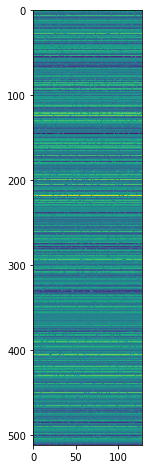

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

image = attentions[0].detach().numpy()

fig = plt.figure(figsize=(2, 8))
plt.imshow(image.transpose())


In [ ]:
class MultiLayerPerceptron(nn.Module):
  def __init__(self, 
               embed_dim: int,
               hidden_dim: int = None, 
               residual_dropout: float = 0.1):
    """
    The input and output dimension is embed_dim (d_model = 512)
    The hidden dim for feed-forward layer is embed_dim * 4 (d_model*4 = 2048) 

    FFN(x) = max(0, xW1 + b1)W2 + b2

    """    
    super(MultiLayerPerceptron, self).__init__()

    if hidden_dim == None:
      hidden_dim = 4 * embed_dim

    self.hidden_layer_1 = nn.Linear(in_features=embed_dim, 
                                    out_features=hidden_dim)
    self.gelu = nn.GELU()
    self.hidden_layer_2 = nn.Linear(in_features=hidden_dim, 
                                    out_features=embed_dim)
    self.res_dropout = nn.Dropout(p=residual_dropout) 

    self.mlp = nn.Sequential(
        self.hidden_layer_1, 
        self.gelu, 
        self.hidden_layer_2,
        self.res_dropout
    )

  def forward(self, X):
    return self.mlp(X)


In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, 
               config: TransformerConfig):
    super(TransformerBlock, self).__init__()

    self.embed_dim = config.embed_dim
    self.num_heads = config.num_heads
    
    self.multi_head_self_attention_layer = MultiHeadSelfAttention(
        self.embed_dim,
        self.num_heads,
        activation=config.activation,
        bias=config.bias,
        attention_dropout=config.attention_dropout, 
        residual_dropout=config.residual_dropout, 
        mask=config.mask
    )

    self.feed_forward_layer = MultiLayerPerceptron(
        self.embed_dim,
        residual_dropout=config.residual_dropout
    )

    self.layer_norm_attn = nn.LayerNorm(self.embed_dim)
    self.layer_norm_ff = nn.LayerNorm(self.embed_dim)

    
  def forward(self, X):
    X = X + self.multi_head_self_attention_layer(self.layer_norm_attn(X))
    X = X + self.feed_forward_layer(self.layer_norm_ff(X))

    return X

In [ ]:
class TransformerModel(nn.Module):
  def __init__(self):
    super(TransformerModel, self).__init__()
  def forward(self):
    pass

In [ ]:
config = TransformerConfig(2000, 128, 512, hidden_dim=4056, embedding_dropout=0.2)

In [ ]:
mlp = MultiLayerPerceptron(config.embed_dim)